In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as spio
import getpass
import os
import csv

In [106]:
########## Variables #############
Blank_zone = 0.11
Vbeam = 7.32 # distance of vertical sample

plot_vert_prof = True # Plot vertical profile
save_vert_prof = False # Save vertical profile to file

plot_cross_sec = False

save_mid_depths = False

folder_file_save = "../output_images/{}.png"
folder_csv_save = "../data/{}.csv"
depths_adcp_for_adv = folder_csv_save.format('depths_adcp_for_adv')
##################################

In [107]:
# Was function smartpulsehd on?
smartpulsehd = np.array([1, 1, 0, 0, 0, 1])

# Number of days in total
numdays = 6

# Name of the computer
myhost = getpass.getuser()

# Base folder
datafolder = 'C:/Users/username/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/'.replace('username', myhost)# basefolder
basefolder = datafolder+'Sontek'

# Subfolders
daynames = [i[3:] for i in os.listdir(basefolder)]

# Four different qs per time period
allqs = [np.zeros(numdays) for i in range(4)]

# Count the number of days
day = 0



In [108]:
# Open Excel with ADV results
advexcel = datafolder+'ADVmeasurements.xlsx'


Monday morning
20051002095139.mat 1
Transducerdepth:  Monday morning 20051002095139.mat 0.07
20051002095859.mat 0
Transducerdepth:  Monday morning 20051002095859.mat 0.07
20051002100742.mat

C:\Users\Sjoerd Gn\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Sjoerd Gn\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in arctan


 1
Transducerdepth:  Monday morning 20051002100742.mat 0.07
20051002101138.mat 0
Transducerdepth:  Monday morning 20051002101138.mat 0.07

Mean Qs 0
Mean right Q =  0.0003096332057860718 m^3/s
Mean left Q =  0.0 m^3/s
Mean top Q =  0.4411686607700176 m^3/s
Mean middle Q =  1.2061205504626862 m^3/s
Sum all 1.6479084776442758
Total Q 2.0281638998179554

Monday afternoon
20051002153808.mat 1
Transducerdepth:  Monday afternoon 20051002153808.mat 0.07
20051002154435.mat 0
Transducerdepth:  Monday afternoon 20051002154435.mat 0.07
20051002155011.mat 1
Transducerdepth:  Monday afternoon 20051002155011.mat 0.07
20051002160639.mat 0
Transducerdepth:  Monday afternoon 20051002160639.mat 0.07
20051002164153.mat 1
Transducerdepth:  Monday afternoon 20051002164153.mat 0.0

Mean Qs 1
Mean right Q =  0.0011416494628508286 m^3/s
Mean left Q =  0.0 m^3/s
Mean top Q =  0.3744801145730435 m^3/s
Mean middle Q =  1.148402411506892 m^3/s
Sum all 1.5251658250056372
Total Q 1.4305656642622515

Tuesday morning

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

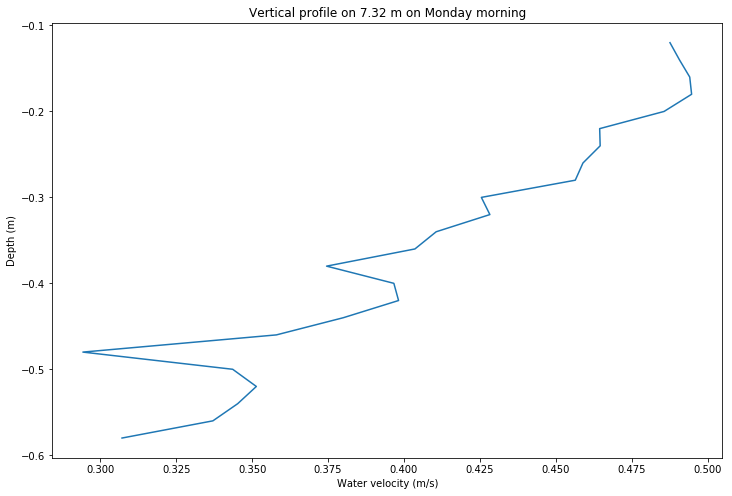

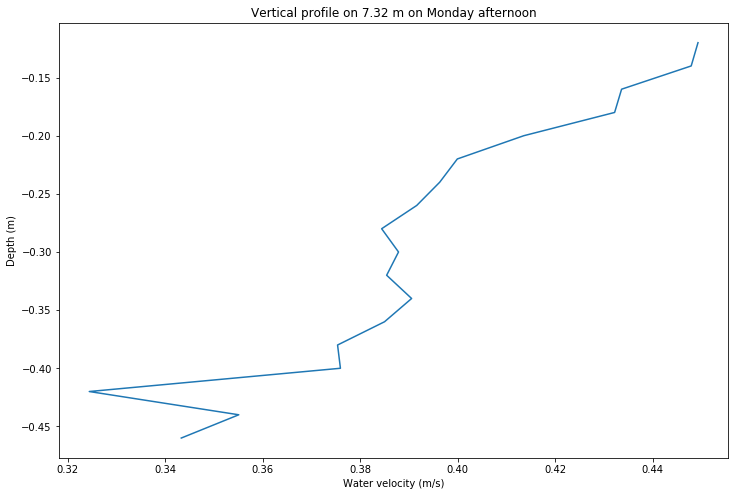

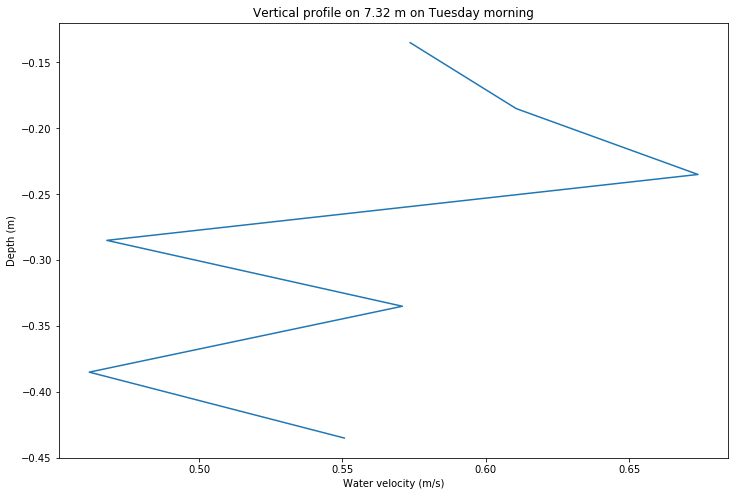

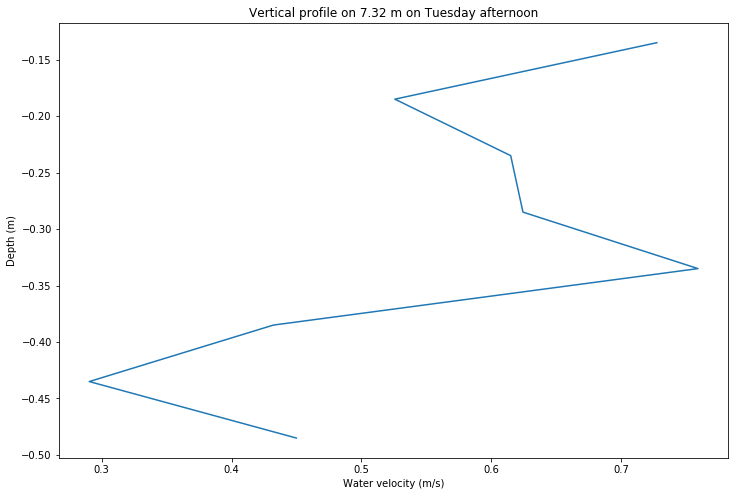

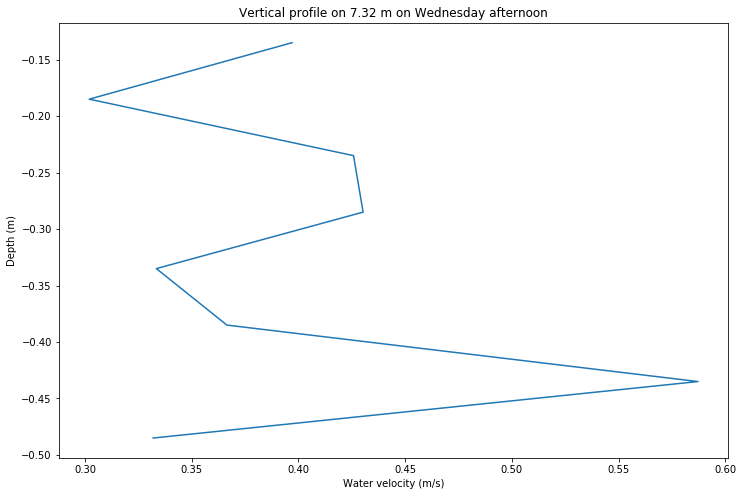

In [109]:


# loop over all roots
for root, dirs, files in os.walk(basefolder, topdown=False):
    
    # Don't look in the basefolder
    if root == basefolder:
        continue
        
    # which folder are we doing right now?
    print(daynames[day])
    
    
    
    # Per time period, save the number of depth cells
    tot_xs = {}
    len_xs = 1000
    
    # Files that we want to use
    goodfiles = [file for file in files if (file[-4:] == '.mat') and (file[-5:] != 'y.mat')] 
    
    # Total Qs to be saved
    tot_rightq = np.zeros(len(goodfiles))
    tot_leftq = np.zeros_like(tot_rightq)
    tot_topq = np.zeros_like(tot_rightq)
    tot_middleq = np.zeros_like(tot_rightq)
    
    # Read the Excel of the ADV measurements
    adv = pd.read_excel(advexcel, sheet_name=daynames[day])
    meas_locs = adv.iloc[2, 1:].dropna()

    # Save depths in middle
    tot_middepths = np.zeros((len(meas_locs), len(goodfiles)))
    
    # Remember the number of the file
    filenum = 0
    
    # Loop over the correct files in the folder
    for file in goodfiles:
        
        # Load direction from file in folder
        direction = int(np.loadtxt(root+'/direction.txt', delimiter = ',')[filenum])
        print(file, direction)

        # Load the file
        matfile = root+'/'+file
        mat = spio.loadmat(matfile)

        
        ### Qs ###
        # Load the extrapolated qs
        RightQ = mat['Summary']['Right_Q'][()][0][0][-1][0]
        LeftQ = mat['Summary']['Left_Q'][()][0][0][-1][0]
        TopQ = mat['Summary']['Top_Q'][()][0][0][-1][0]
        # Load calculated 
        MiddleQ = mat['Summary']['Middle_Q'][()][0][0][-1][0]
        BottomQ = mat['Summary']['Bottom_Q'][()][0][0][-1][0]
        TopQ = mat['Summary']['Top_Q'][()][0][0][-1][0]
        # Load total discharge
        Discharge   = mat['Summary']['Total_Q'][()][0][0]     # discharge
        
        # Save total Qs such that average can be taken
        tot_rightq[filenum] = RightQ
        tot_leftq[filenum] = LeftQ
        tot_topq[filenum] = TopQ
        tot_middleq[filenum] = MiddleQ

        # Print the transducerdepth
        TransducerDepth = mat['Setup']['sensorDepth'][()][0][0][0][0]
        print('Transducerdepth: ', daynames[day], file, TransducerDepth)

        Vmean = mat['Summary']['Mean_Vel'][()][:,0][0][0] # = nanmean(Vprofile,1)   # average velocity averaged over the depth   

        # Load measured depth per column
        Depth = mat['Summary']['Depth'][()][0][0] 
        
        # Load the number of cells per column
        Cells = (mat['Summary']['Cells'][()])[0][0]#.astype('int')                   # number of cells for each vertical beam
        Cells = np.array([int(Cells[i][0]) for i in range(len(Cells))])
        
        # Load cell sizes
        Cellsize = mat['System']['Cell_Size'][()][0][0]
        Cellsize = np.array([round(Cellsize[i][0],4) for i in range(len(Cells))])
  
        
        # Load the track of the boat
        Track = mat['Summary']['Track'][()][0][0]    # track location for each sample in X/Y coordinates
        Track_x = np.array([Track[i][0] for i in range(len(Track))])
        Track_y = np.array([Track[i][1] for i in range(len(Track))])
        Distance = np.array([(Track_x[i]**2+Track_y[i]**2)**0.5 for i in range(len(Track_x))]) #np.sum(abs(Track),1)    #this is probably not be correct and it depends how Track is measured. Please check this!

        
        # Load velocity for each of the four beams
        Velocity = mat['WaterTrack']['Velocity'][()][0][0]       # velocity for each of the 4 beams

        if direction==1:  # flip if reverse
            Distance = np.max(Distance)-Distance
            Velocity = - Velocity
        
        Vabs = (Velocity[:,0,:]**2+Velocity[:,1,:]**2)**0.5  # average velocity profile
        
        # Velocity in the direction of the river
        Angle_tot = np.arctan(Track_x[-1]/Track_y[-1])
        Angle_cell = np.arctan(Velocity[:,0,:]/Velocity[:,1,:])
        Angle_dir = 0.5*np.pi-Angle_tot-Angle_cell
        Vprofile = Vabs*np.cos(Angle_dir)
        Vprofile = Vabs
        
        if plot_cross_sec:
            plt.figure(figsize=(8,12))
            plt.imshow(Vprofile[:20, :])
        
        # Depths in the measured area
        Middepths = Cells*Cellsize
        
        # Take out of the middle depths for comparison with the ADV
        for k in range(len(meas_locs)):
            dist_to_loc = np.array([abs(Distance[i]-meas_locs[k]) for i in range(len(Distance))])
            loc_cell = np.argmin(dist_to_loc)
            tot_middepths[k, filenum] = Middepths[loc_cell]

        # Plot the track
        #plt.figure()
        #plt.plot(Track_x, Track_y)
        #plt.axis('equal')

        # Depth_BT    = mat['BottomTrack']['BT_Depth'][()][0][0] # bottom track (BT) depth using 4 beams at 3MHz frequency (smaller depth range, higher resolution). The depth is estimated assuming the river bed does not move and using boat movement information.
        #DepthBeam   = mat['BottomTrack']['BT_Beam_Depth'][()][0][0]                       # total water depth for each beam


        dist_to_vbeam = np.array([abs(Distance[i]-Vbeam) for i in range(len(Distance))])

        Vbeam_cell = np.argmin(dist_to_vbeam)

        y_axis = -Blank_zone-Cellsize[Vbeam_cell]*np.linspace(0.5, Cells[Vbeam_cell]-0.5,Cells[Vbeam_cell])
        x_axis =  Vprofile[0:Cells[Vbeam_cell], Vbeam_cell]

        # x_axis = np.array([(x_axis[i]*2+x_axisplus1[i]+x_axisminus1[i])/4 for i in range(minsides)])
        tot_xs[file] = x_axis

        if len(x_axis) < len_xs:
            len_xs = len(x_axis)
            tot_ys = y_axis #[0:minsides]

        '''
        plt.figure()
        plt.plot(-Depth, 'b')

        plt.plot(-Cellsize*np.array(Cells)-Blank_zone, 'r')
        plt.plot([0,len(Cells)], [-Blank_zone, -Blank_zone], 'r')
        plt.plot([0,len(Cells)], [0,0], 'b')
        '''         
        filenum +=1
    
    # Process the middle depth values
    if save_mid_depths:
        with open(depths_adcp_for_adv, 'a', newline = "") as csv_file:
            avg_middepths =  np.zeros(len(meas_locs))
            for i in range(len(meas_locs)):
                avg_middepths[i] = np.mean(tot_middepths[i, :])

            print("Depths in middle:")
            print(avg_middepths)

            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([daynames[day]]+[l for l in avg_middepths])

    
    
    # Process the vertical profile
    x_axis_tot = np.zeros(len_xs)
    
    for j in range(len_xs):     #depths
        level_tot = np.zeros(len(goodfiles))
        
        i = 0
        for file in goodfiles: #files
            level_tot[i] = tot_xs[file][j]
            i+=1
                
        x_axis_tot[j] = np.mean(level_tot)
    
    # Plot vertical velocity profile
    if plot_vert_prof:
        plt.figure(figsize=(12,8))
        plt.plot(x_axis_tot, tot_ys)
        #plt.ylim((-.6,0))
        #plt.xlim((0, 0.6))
        plt.xlabel('Water velocity (m/s)')
        plt.ylabel('Depth (m)')
        plt.title('Vertical profile on {} m on {}'.format(str(Vbeam), daynames[day]))
        if save_vert_prof:
            plt.savefig(folder_file_save.format('Vert_prof_vbeam_'+str(Vbeam).replace('.',',')+'_'+ daynames[day]))

    # Means of the Qs
    mean_rightq = np.mean(tot_rightq)
    mean_leftq = np.mean(tot_leftq)
    mean_topq = np.mean(tot_topq)
    mean_middleq = np.mean(tot_middleq)

    # Print means
    print()
    print('Mean Qs', day)
    print('Mean right Q = ', mean_rightq, 'm^3/s')
    print('Mean left Q = ', mean_leftq, 'm^3/s')
    print('Mean top Q = ', mean_topq, 'm^3/s')
    print('Mean middle Q = ', mean_middleq, 'm^3/s')
    print('Sum all', sum((mean_rightq, mean_rightq, mean_topq, mean_middleq)))
    print('Total Q', Discharge[-1][0])

    # Save means
    allqs[0][day] = mean_rightq
    allqs[1][day] = mean_leftq
    allqs[2][day] = mean_topq
    allqs[3][day] = mean_middleq
        
    print()
    day += 1


In [ ]:
with open('employee_birthday.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(f'\t{row[0]} works in the {row[1]} department, and was born in {row[2]}.')
            line_count += 1
    print(f'Processed {line_count} lines.')

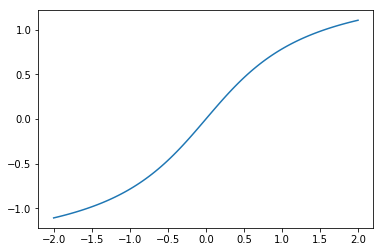

<Figure size 504x504 with 0 Axes>

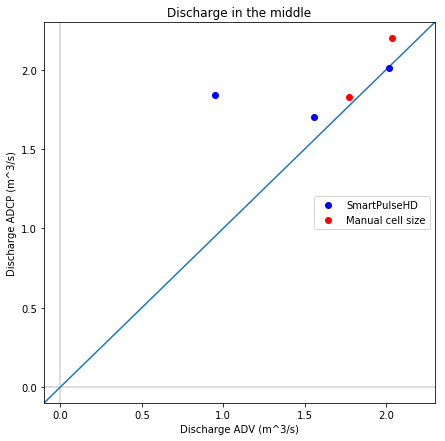

<Figure size 504x504 with 0 Axes>

In [6]:
rightadv = np.array([0.04, 0.05, 0.04, 10000,  0.07, 0.06])
leftadv = np.array([0.03, 0.03, 0.07, 10,  0.06, 0.1])
middleadv = np.array([0.95, 1.56, 1.77, 100,  2.04, 2.02])



plt.figure(figsize=(7,7))
plt.axvline(0, color='lightgray')
plt.axhline(0, color='lightgray')
plt.plot([-3, 3], [-3, 3])
plt.xlim((-.1, 2.3))
plt.ylim((-.1, 2.3))

plt.plot(middleadv[smartpulsehd==1], allqs[3][smartpulsehd==1], 'bo', label = 'SmartPulseHD')
plt.plot(middleadv[smartpulsehd==0], allqs[3][smartpulsehd==0], 'ro', label = 'Manual cell size')
plt.legend()
plt.xlabel('Discharge ADV (m^3/s)')
plt.ylabel('Discharge ADCP (m^3/s)')
plt.title('Discharge in the middle')
plt.savefig('figure1.png')

plt.figure(figsize=(7,7))


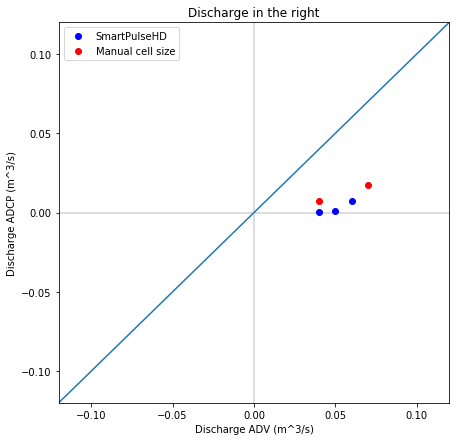

In [7]:
plt.figure(figsize=(7,7))
plt.axvline(0, color='lightgray')
plt.axhline(0, color='lightgray')
plt.plot([-3, 3], [-3, 3])

plt.xlim((-0.12, 0.12))
plt.ylim((-0.12, 0.12))

plt.plot(rightadv[smartpulsehd==1], allqs[0][smartpulsehd==1], 'bo', label = 'SmartPulseHD')
plt.plot(rightadv[smartpulsehd==0], allqs[0][smartpulsehd==0], 'ro', label = 'Manual cell size')
plt.legend()
plt.xlabel('Discharge ADV (m^3/s)')
plt.ylabel('Discharge ADCP (m^3/s)')
plt.title('Discharge in the right')
plt.savefig('figure2.png')


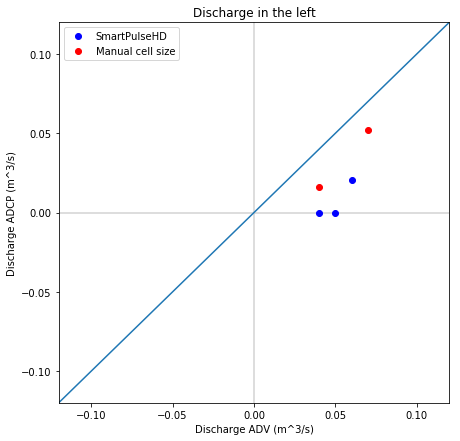

In [8]:
plt.figure(figsize=(7,7))
plt.axvline(0, color='lightgray')
plt.axhline(0, color='lightgray')
plt.plot([-3, 3], [-3, 3])
plt.xlim((-0.12, 0.12))
plt.ylim((-0.12, 0.12))

plt.plot(rightadv[smartpulsehd==1], allqs[1][smartpulsehd==1], 'bo', label = 'SmartPulseHD')
plt.plot(rightadv[smartpulsehd==0], allqs[1][smartpulsehd==0], 'ro', label = 'Manual cell size')
plt.legend()
plt.xlabel('Discharge ADV (m^3/s)')
plt.ylabel('Discharge ADCP (m^3/s)')
plt.title('Discharge in the left')
plt.savefig('figure3.png')

In [9]:
# get depths

In [10]:
# loop over all roots
for root, dirs, files in os.walk(basefolder, topdown=False):
    

        
    # which folder are we doing right now?
    print(root)
    
    # Per time period, save the number of depth cells
    tot_xs = {}
    len_xs = 1000
    
    # Files that we want to use
    goodfiles = [file for file in files if (file[-4:] == '.mat') and (file[-5:] != 'y.mat')] 
    
    # Total Qs to be saved
    tot_rightq = np.zeros(len(goodfiles))
    tot_leftq = np.zeros_like(tot_rightq)
    tot_topq = np.zeros_like(tot_rightq)
    tot_middleq = np.zeros_like(tot_rightq)
    
    filenum = 0

C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek\1. Monday morning
C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek\2. Monday afternoon
C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek\3. Tuesday morning
C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek\4. Tuesday afternoon
C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek\6. Wednesday afternoon
C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek\7. Thursday morning
C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek


In [40]:
testarray = np.array([1,2,3])
np.arctan(0.5-testarray)

array([-0.46364761, -0.98279372, -1.19028995])

In [52]:
np.arctan(1)

0.7853981633974483